## DeBERTa + BiLSTM NLI Model Training

This notebook fine-tunes a custom **DeBERTa + BiLSTM** model for a **binary Natural Language Inference (NLI)** task.

The objective is to predict whether a given *hypothesis* logically follows from a *premise*. The model leverages:
- A pretrained **DeBERTa-v3-base** transformer for rich contextual embeddings.
- A **bidirectional LSTM** to capture sequential dependencies.
- A **fully connected classifier** for final binary classification.

This training pipeline includes:
- Dataset loading and tokenization using HuggingFace.
- Model architecture definition and training loop.
- Hyperparameter setup and optimizer configuration.
- Training for 6 epochs and model evaluation on a validation set.
- Saving the trained model and generating predictions on the validation set.


In [ ]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from transformers import AutoModel, AutoTokenizer

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


## Load Train and Validation Data

We begin by importing and reading the `train.csv` and `dev.csv` files containing premise–hypothesis pairs and binary labels for entailment.


In [ ]:
# Load tokenizer and datasets
tokenizer = AutoTokenizer.from_pretrained("microsoft/deberta-v3-base")
df_train = pd.read_csv("/kaggle/input/nli-dataset/train.csv")
df_val = pd.read_csv("/kaggle/input/nli-dataset/dev.csv")


/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:561: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


## Initialize DeBERTa Tokenizer

We use the `microsoft/deberta-v3-base` tokenizer from HuggingFace Transformers to tokenize the text inputs. The inputs are padded and truncated to a maximum length of 128 tokens.


In [ ]:
class NLIDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

    def __len__(self):
        return len(self.labels)

def tokenize_premise_hypothesis(premises, hypotheses, max_length=128):
    return tokenizer(
        premises,
        hypotheses,
        padding='max_length',
        truncation=True,
        max_length=max_length,
        return_tensors='pt'
    )


## Define NLI Dataset Class

A custom `NLIDataset` class wraps the tokenized inputs and labels, allowing seamless loading into PyTorch DataLoaders. Each item includes:
- `input_ids`
- `attention_mask`
- `labels`


## Model Architecture: DeBERTa + BiLSTM

The model architecture is defined as follows:

- **Base Encoder**: `microsoft/deberta-v3-base`, output dimension: 768
- **LSTM Layer**:
  - Type: Bidirectional LSTM
  - Input size: 768
  - Hidden dimension: 384 (x2 due to bidirectionality → 768 total)
  - Num layers: 1
  - Batch-first format
- **Dropout**: 0.3892 (to reduce overfitting)
- **Fully Connected Layer**: `Linear(768, 2)` for binary classification

Forward pass:
- Input tokens are passed through DeBERTa to get contextual embeddings.
- Embeddings are fed into the BiLSTM.
- The first hidden state is pooled.
- Dropout is applied.
- Output logits are generated by the classifier.


In [ ]:
class DeBERTaWithBiLSTM(nn.Module):
    def __init__(self, hidden_dim=384, dropout=0.3892):
        super().__init__()
        self.base_model = AutoModel.from_pretrained("microsoft/deberta-v3-base")
        self.bilstm = nn.LSTM(768, hidden_dim, num_layers=1, bidirectional=True, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.classifier = nn.Linear(hidden_dim * 2, 2)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.base_model(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs.last_hidden_state
        lstm_out, _ = self.bilstm(sequence_output)
        pooled_output = lstm_out[:, 0]
        out = self.dropout(pooled_output)
        logits = self.classifier(out)
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss = loss_fn(logits, labels)
            return {'loss': loss, 'logits': logits}
        return {'logits': logits}


## Training Hyperparameters

The following hyperparameters were selected (e.g., via Optuna tuning):

- `learning_rate`: 8.66e-6
- `weight_decay`: 4.37e-4
- `dropout`: 0.3892
- `hidden_dim`: 384
- `batch_size`: 32
- `num_epochs`: 6

Optimizer used: `AdamW`
Loss function: `CrossEntropyLoss`


In [ ]:
# Best hyperparameters from Optuna
learning_rate = 8.663394579529044e-06
weight_decay = 0.00043725068136265345
dropout = 0.38920213235632034
hidden_dim = 384
batch_size = 32
num_epochs = 6

## Training Loop

The model is trained for 6 epochs. At each epoch:

1. The model is trained on the entire training set using backpropagation.
2. Validation is performed on the `dev.csv` split.
3. Validation loss and accuracy are tracked.
4. Gradient clipping is applied to a max norm of 1.0 to avoid exploding gradients.
5. The best model weights are retained.

Both training and validation losses are logged per epoch for later visualization.


In [ ]:
train_enc = tokenize_premise_hypothesis(df_train['premise'].tolist(), df_train['hypothesis'].tolist())
val_enc = tokenize_premise_hypothesis(df_val['premise'].tolist(), df_val['hypothesis'].tolist())

train_labels = torch.tensor(df_train['label'].values)
val_labels = torch.tensor(df_val['label'].values)

train_dataset = NLIDataset(train_enc, train_labels)
val_dataset = NLIDataset(val_enc, val_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)


During each training epoch, the model performs the following steps:

1. **Training Phase**
   - The model is set to training mode.
   - For each batch in the training data:
     - Gradients are reset.
     - Forward pass is performed to compute the loss.
     - Backward pass is executed to compute gradients.
     - Gradient clipping (`max_norm=1.0`) is applied to prevent exploding gradients.
     - The optimizer updates the model weights.
   - The average training loss for the epoch is calculated and stored.

2. **Validation Phase**
   - The model is switched to evaluation mode.
   - No gradients are computed.
   - For each batch in the validation data:
     - The loss and predictions are computed.
     - Predictions and ground truth labels are collected for accuracy calculation.
   - Average validation loss and accuracy are computed and logged.

Metrics tracked per epoch:
- `train_losses`: average training loss
- `val_losses`: average validation loss
- `val_accuracies`: accuracy on the validation set

At the end of each epoch, the current training/validation performance is printed to the console.

In [ ]:
model = DeBERTaWithBiLSTM(hidden_dim=hidden_dim, dropout=dropout).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_losses, val_losses, val_accuracies = [], [], []

for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch in train_loader:
        optimizer.zero_grad()
        outputs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device),
            labels=batch["labels"].to(device)
        )
        loss = outputs["loss"]
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation
    model.eval()
    all_preds, all_labels = [], []
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            outputs = model(
                input_ids=batch["input_ids"].to(device),
                attention_mask=batch["attention_mask"].to(device),
                labels=batch["labels"].to(device)
            )
            loss = outputs["loss"]
            total_val_loss += loss.item()
            preds = torch.argmax(outputs["logits"], dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch["labels"].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_loader)
    val_acc = accuracy_score(all_labels, all_preds)
    val_losses.append(avg_val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} ✅ Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/6 ✅ Train Loss: 0.3708 | Val Loss: 0.2391 | Val Acc: 0.9109
Epoch 2/6 ✅ Train Loss: 0.1922 | Val Loss: 0.2566 | Val Acc: 0.9132
Epoch 3/6 ✅ Train Loss: 0.1285 | Val Loss: 0.2899 | Val Acc: 0.9164
Epoch 4/6 ✅ Train Loss: 0.0917 | Val Loss: 0.3322 | Val Acc: 0.9175
Epoch 5/6 ✅ Train Loss: 0.0675 | Val Loss: 0.3538 | Val Acc: 0.9195
Epoch 6/6 ✅ Train Loss: 0.0480 | Val Loss: 0.4154 | Val Acc: 0.9198


## Save Trained Model

The best model is saved to disk using `torch.save()` and also zipped for deployment or submission. The file saved is:
- `best_deberta_bilstm_model.pt`
- Zipped version: `deberta_model.zip`


In [ ]:
torch.save(model.state_dict(), "best_deberta_bilstm_model_resave.pt")
print("✅ Model saved successfully!")


✅ Model saved successfully!


In [ ]:
import zipfile

with zipfile.ZipFile("/kaggle/working/deberta_model.zip", "w") as zipf:
    zipf.write("/kaggle/working/best_deberta_bilstm_model.pt", arcname="best_deberta_bilstm_model.pt")

print("✅ Model zipped successfully as deberta_model.zip")


✅ Model zipped successfully as deberta_model.zip


## Generate and Save Predictions

Predictions on the validation set are computed using the trained model in evaluation mode. These predictions are appended to the `dev.csv` file and exported to `predictions.csv` for further analysis.


In [ ]:
# Predict on validation set
model.eval()
all_preds = []
with torch.no_grad():
    for batch in val_loader:
        outputs = model(
            input_ids=batch["input_ids"].to(device),
            attention_mask=batch["attention_mask"].to(device)
        )
        preds = torch.argmax(outputs["logits"], dim=1)
        all_preds.extend(preds.cpu().numpy())

# Save predictions
df_val["prediction"] = all_preds
df_val.to_csv("predictions.csv", index=False)
print("✅ Predictions saved to predictions.csv")


✅ Predictions saved to predictions.csv


In [ ]:
print("\nClassification Report:\n")
print(classification_report(df_val['label'], df_val['prediction']))

print("Confusion Matrix:")
print(confusion_matrix(df_val['label'], df_val['prediction']))



Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.90      0.92      3258
           1       0.91      0.93      0.92      3478

    accuracy                           0.92      6736
   macro avg       0.92      0.92      0.92      6736
weighted avg       0.92      0.92      0.92      6736

Confusion Matrix:
[[2947  311]
 [ 229 3249]]


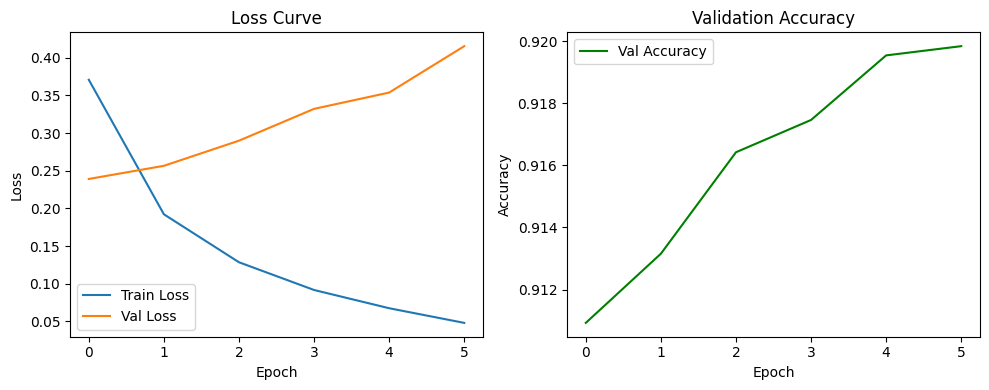

In [ ]:
plt.figure(figsize=(10,4))

plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1,2,2)
plt.plot(val_accuracies, label='Val Accuracy', color='green')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()
